In [1]:
import pandas as pd
import math
import numpy as np
import random
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt
from MEBF import MEBF, matrix_subtract, matrix_product
import seaborn as sns
import time
import scipy
%matplotlib inline

In [2]:
data = pd.read_csv("gene.csv",index_col = 0)

Text(0, 0.5, 'explained variance ratio(%)')

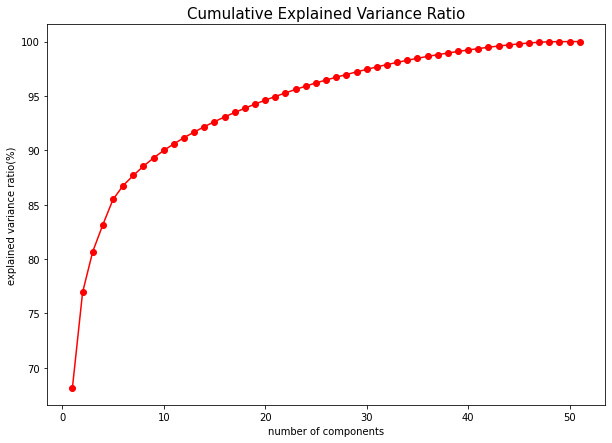

In [8]:
from sklearn.preprocessing import scale
data_norm = scale(data)
pca = PCA(n_components = 'mle')
pca.fit(data_norm)
evr = pca.explained_variance_ratio_ * 100
# 查看累计解释方差比率与主成分个数的关系
fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(np.arange(1, len(evr) + 1), np.cumsum(evr), "-ro")
ax.set_title("Cumulative Explained Variance Ratio", fontsize=15)
ax.set_xlabel("number of components")
ax.set_ylabel("explained variance ratio(%)")

In [4]:
data_norm = scale(data)
pca = PCA(n_components = 2)
pca.fit(data_norm)
pca_df = pca.transform(data_norm)
pca_df.shape

(23684, 2)

In [5]:
u = pca.components_.reshape([52,2])
z = u.T.dot(data_norm.T)
df_approx = u.dot(z).reshape(data.shape)

In [6]:
data_res = pd.DataFrame(data=(data_norm-df_approx),index = data.index, columns = data.columns)

In [7]:
data_res.head(3)

,CY58_1_CD45_F08_S1028_comb,CY58_1_CD45_A05_S965_comb,CY58_1_CD45_D01_S997_comb,cy80.Cd45.pos.Pd1.neg.S293.E05.S293.comb,cy82.CD45.pos.3.A07.S7.comb,cy82.CD45.pos.3.B08.S20.comb,cy53.1.CD45.pos.2.A04.S964.comb,cy53.1.CD45.pos.1.D01.S37.comb,cy53.1.CD45.pos.2.B08.S980.comb,cy53.1.CD45.pos.1.F04.S64.comb,...,cy60_1_cd_45_pos_3_C04_S316_comb,CY89FNA_A03_S195_comb,CY88CD45POS_2_F07_S451_comb,CY88CD45_150813_D05_S329_comb,CY88CD45POS_2_G06_S462_comb,CY94CD45POS_1_E04_S148_comb,CY88CD45POS_2_F09_S453_comb,CY84_PRIM_POS_All_7_E07_S247_comb,CY84_PRIM_POS_All_7_B06_S210_comb,CY84_PRIM_POS_All_8_E10_S154_comb
C9orf152,-0.046124,-3.545455,-0.062904,0.006041,-0.010713,-0.009014,-0.043557,-0.075699,-0.017701,-0.044791,...,-0.100306,-0.008015,-0.029219,-0.162966,-0.033382,0.008594,-0.022169,-0.000458,0.015679,0.007504
RPS11,9.229329,8.760094,2.113379,2.894422,0.841377,5.114128,7.937011,4.039091,17.063287,7.272768,...,4.690430,2.870081,7.721619,7.468801,10.606953,7.092032,3.268144,-0.087569,1.324649,3.287528
ELMO2,1.229986,-0.047597,-0.042117,-0.079039,0.003833,0.149355,-0.027639,-0.025661,0.089242,-0.022666,...,-0.060442,-0.007436,1.495882,0.004034,-0.033106,-0.000725,-0.053493,0.000876,1.008937,0.007504


<AxesSubplot:>

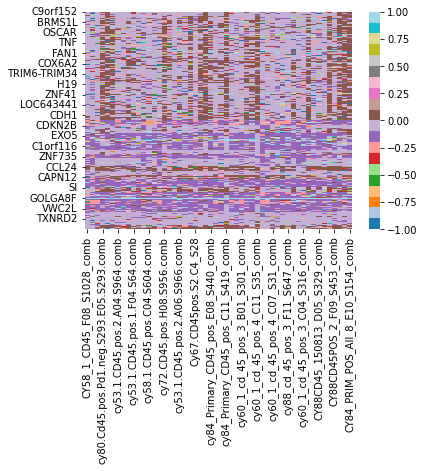

In [64]:
sns.heatmap(data_res, annot=False, vmin=-1, vmax=1, cmap="tab20")

In [11]:
x_in_paper = pd.DataFrame(np.array([[1,1,0,1,1,1,0,1,0,0,0],[1,1,1,1,1,1,1,1,1,1,1],[1,1,0,1,1,1,1,0,1,0,1],
         [0,1,0,0,0,0,0,0,0,0,0],[1,1,1,1,1,1,1,1,1,0,0],[1,1,1,1,1,1,1,0,1,0,0],
         [0,0,0,1,0,0,0,0,0,0,0],[1,1,1,1,1,1,1,1,1,1,0],[1,1,0,1,0,1,1,0,0,0,0],
         [1,1,1,1,1,0,0,0,0,0,0,],[1,1,0,1,1,0,0,0,0,0,0]]), index = range(1,12), columns = range(1,12))
A,B = MEBF(x_in_paper,0.8)

<AxesSubplot:>

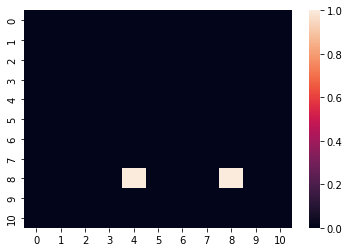

In [12]:
sns.heatmap(matrix_subtract(x_in_paper.values, matrix_product(A.values, B.values)), annot=False, vmin=0, vmax=1)

# Now focus on BCV, to see what it could bring to us

# To satisfy T test, iteration >= 30 is set.

In [78]:
def bcv(data,times=20, num_comps=20, left_1=5, left_2=5):
    # times = 15
    # num_comps = 25
    x = pd.DataFrame(scale(data),index = data.index, columns = data.columns)
    error = pd.DataFrame(index = range(1,times+1), columns = range(1,num_comps+1))
    # iterate over number of components
    for num in range(1,num_comps+1):
        for time in range(1,times+1):
            # shuffle x
            x = x[np.random.permutation(x.columns)]
            x = x.reindex(np.random.permutation(x.index))
            # Since it is (23684,52), submatrix size is chosen as (100,5)
            # leave out submatrix
            A = x.values[:left_1,:left_2]
            B = x.values[:left_1,left_2:]
            C = x.values[left_1:,:left_2]
            D = x.values[left_1:,left_2:]
            # perform PCA
            pca = PCA(n_components = num)
            pca.fit(D)
            u = pca.components_.reshape([D.shape[1],-1])
            z = u.T.dot(D.T)
            D_approx = u.dot(z).reshape(D.shape)
            residule = np.dot( np.dot(B,np.linalg.pinv(D_approx)), C) - A
            error.loc[time][num] = sum(np.abs(residule)).sum()
    return error

## 1) Try small submatrix

In [83]:
times = 30
num_comps = 20
error_1 = bcv(pre,times,num_comps,5,5)
for i in range(1,num_comps):
    print("Meaningful component between ",i, i+1, 
          (ttest_ind(error_1[i],error_1[i+1], equal_var = False).pvalue >= 0.05))

Meaningful component between  1 2 False
Meaningful component between  2 3 True
Meaningful component between  3 4 True
Meaningful component between  4 5 True
Meaningful component between  5 6 True
Meaningful component between  6 7 True
Meaningful component between  7 8 True
Meaningful component between  8 9 True
Meaningful component between  9 10 True
Meaningful component between  10 11 True
Meaningful component between  11 12 True
Meaningful component between  12 13 True
Meaningful component between  13 14 True
Meaningful component between  14 15 True
Meaningful component between  15 16 True
Meaningful component between  16 17 True
Meaningful component between  17 18 True
Meaningful component between  18 19 True
Meaningful component between  19 20 True


## 2) Try large submatrix

In [84]:
times = 30
num_comps = 20
error_2 = bcv(pre,times,num_comps,20,5)
for i in range(1,num_comps):
    print("Meaningful component between ",i, i+1, 
          (ttest_ind(error_2[i],error_2[i+1], equal_var = False).pvalue >= 0.05))

Meaningful component between  1 2 True
Meaningful component between  2 3 True
Meaningful component between  3 4 True
Meaningful component between  4 5 True
Meaningful component between  5 6 True
Meaningful component between  6 7 True
Meaningful component between  7 8 True
Meaningful component between  8 9 True
Meaningful component between  9 10 True
Meaningful component between  10 11 False
Meaningful component between  11 12 True
Meaningful component between  12 13 True
Meaningful component between  13 14 True
Meaningful component between  14 15 True
Meaningful component between  15 16 True
Meaningful component between  16 17 True
Meaningful component between  17 18 True
Meaningful component between  18 19 True
Meaningful component between  19 20 True


## 3) Even larger

In [85]:
times = 30
num_comps = 20
error_3 = bcv(pre,times,num_comps,40,5)
for i in range(1,num_comps):
    print("Meaningful component between ",i, i+1, 
          (ttest_ind(error_3[i],error_3[i+1], equal_var = False).pvalue >= 0.05))

Meaningful component between  1 2 True
Meaningful component between  2 3 True
Meaningful component between  3 4 True
Meaningful component between  4 5 True
Meaningful component between  5 6 True
Meaningful component between  6 7 True
Meaningful component between  7 8 False
Meaningful component between  8 9 True
Meaningful component between  9 10 True
Meaningful component between  10 11 True
Meaningful component between  11 12 True
Meaningful component between  12 13 False
Meaningful component between  13 14 True
Meaningful component between  14 15 True
Meaningful component between  15 16 True
Meaningful component between  16 17 True
Meaningful component between  17 18 True
Meaningful component between  18 19 True
Meaningful component between  19 20 True


## How about leave out 3%, 5%, 7%, 10%

In [90]:
times = 30
num_comps = 20
error_3p = bcv(pre,times,num_comps,round(pre.shape[0]*0.03),round(pre.shape[1]*0.03))
for i in range(1,num_comps):
    print("Meaningful component between ",i, i+1, 
          (ttest_ind(error_3p[i],error_3p[i+1], equal_var = False).pvalue >= 0.05))

Meaningful component between  1 2 True
Meaningful component between  2 3 True
Meaningful component between  3 4 True
Meaningful component between  4 5 True
Meaningful component between  5 6 True
Meaningful component between  6 7 True
Meaningful component between  7 8 True
Meaningful component between  8 9 False
Meaningful component between  9 10 True
Meaningful component between  10 11 True
Meaningful component between  11 12 True
Meaningful component between  12 13 True
Meaningful component between  13 14 True
Meaningful component between  14 15 True
Meaningful component between  15 16 True
Meaningful component between  16 17 True
Meaningful component between  17 18 True
Meaningful component between  18 19 True
Meaningful component between  19 20 True


In [97]:
times = 30
num_comps = 20
error_5p = bcv(pre,times,num_comps,round(pre.shape[0]*0.05),round(pre.shape[1]*0.05))
for i in range(1,num_comps):
    print("Meaningful component between ",i, i+1, 
          (ttest_ind(error_5p[i],error_5p[i+1], equal_var = False).pvalue >= 0.05))

Meaningful component between  1 2 True
Meaningful component between  2 3 True
Meaningful component between  3 4 True
Meaningful component between  4 5 True
Meaningful component between  5 6 False
Meaningful component between  6 7 True
Meaningful component between  7 8 True
Meaningful component between  8 9 True
Meaningful component between  9 10 True
Meaningful component between  10 11 True
Meaningful component between  11 12 True
Meaningful component between  12 13 True
Meaningful component between  13 14 True
Meaningful component between  14 15 True
Meaningful component between  15 16 True
Meaningful component between  16 17 True
Meaningful component between  17 18 True
Meaningful component between  18 19 True
Meaningful component between  19 20 True


In [101]:
times = 30
num_comps = 20
error_7p = bcv(pre,times,num_comps,round(pre.shape[0]*0.07),round(pre.shape[1]*0.07))
for i in range(1,num_comps):
    print("Meaningful component between ",i, i+1, 
          (ttest_ind(error_7p[i],error_7p[i+1], equal_var = False).pvalue >= 0.05))

Meaningful component between  1 2 True
Meaningful component between  2 3 True
Meaningful component between  3 4 True
Meaningful component between  4 5 True
Meaningful component between  5 6 True
Meaningful component between  6 7 True
Meaningful component between  7 8 True
Meaningful component between  8 9 True
Meaningful component between  9 10 True
Meaningful component between  10 11 True
Meaningful component between  11 12 False
Meaningful component between  12 13 False
Meaningful component between  13 14 False
Meaningful component between  14 15 True
Meaningful component between  15 16 True
Meaningful component between  16 17 True
Meaningful component between  17 18 True
Meaningful component between  18 19 False
Meaningful component between  19 20 True


In [93]:
times = 30
num_comps = 20
error_10p = bcv(pre,times,num_comps,round(pre.shape[0]*0.1),round(pre.shape[1]*0.1))
for i in range(1,num_comps):
    print("Meaningful component between ",i, i+1, 
          (ttest_ind(error_10p[i],error_10p[i+1], equal_var = False).pvalue >= 0.05))

Meaningful component between  1 2 True
Meaningful component between  2 3 True
Meaningful component between  3 4 True
Meaningful component between  4 5 True
Meaningful component between  5 6 True
Meaningful component between  6 7 True
Meaningful component between  7 8 True
Meaningful component between  8 9 True
Meaningful component between  9 10 True
Meaningful component between  10 11 True
Meaningful component between  11 12 True
Meaningful component between  12 13 True
Meaningful component between  13 14 True
Meaningful component between  14 15 True
Meaningful component between  15 16 True
Meaningful component between  16 17 True
Meaningful component between  17 18 True
Meaningful component between  18 19 True
Meaningful component between  19 20 True


## Personally, I prefer 5%

In [111]:
times = 30
num_comps = 20
error_t = bcv(pre,times,num_comps,round(pre.shape[0]*0.05),round(pre.shape[1]*0.05))
candidate = []
for i in range(1,num_comps):
    print("Meaningful component between ",i, i+1, 
          (ttest_ind(error_t[i],error_t[i+1], equal_var = False).pvalue >= 0.05))
    if (not (ttest_ind(error_t[i],error_t[i+1], equal_var = False).pvalue >= 0.05)):
        candidate.append(i+1)

Meaningful component between  1 2 True
Meaningful component between  2 3 True
Meaningful component between  3 4 True
Meaningful component between  4 5 True
Meaningful component between  5 6 True
Meaningful component between  6 7 True
Meaningful component between  7 8 True
Meaningful component between  8 9 True
Meaningful component between  9 10 True
Meaningful component between  10 11 True
Meaningful component between  11 12 True
Meaningful component between  12 13 True
Meaningful component between  13 14 True
Meaningful component between  14 15 True
Meaningful component between  15 16 True
Meaningful component between  16 17 True
Meaningful component between  17 18 True
Meaningful component between  18 19 True
Meaningful component between  19 20 True


In [112]:
candidate

[]